# Execution of the verifiers on the dataset

#### Some config

In [2]:
NUM_PROC = 1

## Execution Code

In [3]:
from collections import defaultdict
from vif.baselines.models import VerEvaluation
from vif.baselines.verifiers_baseline.ver_baseline import TexVerBaseline
from datasets.formatting.formatting import LazyBatch
from PIL import Image
import sys
from datasets import load_dataset, Dataset
from loguru import logger

from vif.utils.renderer.tex_renderer import TexRenderer

renderer = TexRenderer()


def execute_verifier_on_dataset(verifier: TexVerBaseline, dataset: Dataset, n=1):
    def exec_verif(row: LazyBatch,indice:int):
        metadata = verifier.get_config_metadata()
        ver_eval_input: VerEvaluation = VerEvaluation(
            id=row["id"][0],
            approach_name=metadata["name"],
            config_metadata=metadata,
            initial_code=row["code"][0],
            initial_image=row["original_image"][0],
            initial_instruction=row["instruction"][0],
            initial_solution=row["solution"][0],
            initial_solution_image=row["solution_image"][0],
            expected=row["expected"][0],
        )
        results: list[VerEvaluation] = []
        for _ in range(n):            
            res = verifier.assess_customization(ver_eval_input)
            
            results.append(res)

        new_rows = defaultdict(list)
        for i, ver_result in enumerate(results):
            res_dict = ver_result.model_dump()
            for key, value in res_dict.items():
                new_rows[key].append(value)
            new_rows["try"].append(i)
            new_rows["index"].append(indice[0])
        return new_rows

    return dataset.map(
        exec_verif,
        num_proc=NUM_PROC,
        batched=True,
        batch_size=1,
        remove_columns=dataset.column_names,
        with_indices=True,
    )
    
    

2025-11-04 09:27:06.831 | INFO     | vif.utils.caching:instantiate_cache:26 - seg_cache cache loaded


## Execution of the verifiers

#### Config

In [5]:
import openai
import os
from google import genai
from google.genai import types as genTypes
from vif.baselines.verifiers_baseline import (
    FalconVerifier,
    TextVerifier,
    TextVisualVerifier,
    ViperGPTVerifier,
    VisualPropertiesVerifier,
    VisualVerifier,
    VisualCodeVerifier,
)


client = openai.Client(
    base_url="https://openrouter.ai/api/v1",
    api_key=os.environ.get("OPENROUTER_API_KEY"),
)

gclient = genai.Client(
        api_key=os.environ.get("GOOGLE_API_KEY"),
        http_options=genTypes.HttpOptions(api_version="v1alpha"),
    )

logger.configure(handlers=[{"sink": sys.stdout, "level": "WARNING"}])
ds = load_dataset("CharlyR/VeriTikz", "full", split="train")
ds =ds.select(range(0,25))


#### Text Verifier

In [14]:
text_verifier: TexVerBaseline = TextVerifier(
    model="qwen/qwen3-vl-32b-instruct", temperature=0.5, client=client
)

verifier_text_ds = execute_verifier_on_dataset(text_verifier, ds, 1)

Map: 100%|██████████| 25/25 [04:40<00:00, 11.22s/ examples]


#### Visual Verifier

In [15]:
visual_verifier: TexVerBaseline = VisualVerifier(
    model="qwen/qwen3-vl-32b-instruct",
    temperature=0.5,
    client=client
)

verifier_visual_ds = execute_verifier_on_dataset(visual_verifier,ds)

Map: 100%|██████████| 25/25 [01:58<00:00,  4.74s/ examples]


#### Text/Visual Verifier

In [18]:
text_visual_verifier: TexVerBaseline = TextVisualVerifier(
    model="qwen/qwen3-vl-32b-instruct",
    temperature=0.5,
    client=client
)

verifier_text_visual_ds = execute_verifier_on_dataset(text_visual_verifier,ds)

Map: 100%|██████████| 25/25 [03:53<00:00,  9.32s/ examples]


#### Visual Verifier with code

In [4]:
text_visual_code_verifier: TexVerBaseline = VisualCodeVerifier(
    model="openai/gpt-5-mini",
    temperature=0.5,
    client=client
)

verifier_visual_code_ds = execute_verifier_on_dataset(text_visual_code_verifier,ds)

Parameter 'function'=<function execute_verifier_on_dataset.<locals>.exec_verif at 0x7b1466e00900> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Map: 100%|██████████| 2/2 [01:40<00:00, 50.07s/ examples]


#### Visual Property Verifier

In [6]:
visual_property_verifier: TexVerBaseline = VisualPropertiesVerifier(
    model="qwen/qwen3-vl-32b-instruct",
    temperature=0.5,
    client=client
)

verifier_visual_property_ds = execute_verifier_on_dataset(visual_property_verifier,ds)

Parameter 'function'=<function execute_verifier_on_dataset.<locals>.exec_verif at 0x7b1d5b0c67a0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Map:   0%|          | 0/25 [00:00<?, ? examples/s]/home/creux/Documents/AI/VIFagent/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `dict[any, any]` - serialized value may not be as expected [input_value=VisualPropertiesVerifierM..., B', or the force F."]), input_type=VisualPropertiesVerifierMetadata])
  PydanticSerializationUnexpectedV

#### ViperGPT Verifier

In [ ]:
#full config available here in config file vif/baselines/verifiers_baseline/ViperGPT_adapt/ViperGPT_config.py
visual_property_verifier: TexVerBaseline = ViperGPTVerifier(
    model="qwen/qwen3-vl-32b-instruct",
    temperature=0.5,
    client=client
)

verifier_vipergpt_ds = execute_verifier_on_dataset(visual_property_verifier,ds)

#### Ours

In [ ]:
falcon_verifier: TexVerBaseline = FalconVerifier(
    oracle_gen_model="qwen/qwen3-vl-32b-instruct",
    oracle_gen_model_temperature=0.5,
    vision_model="gemini-2.5-flash",
    property_model="qwen/qwen3-vl-32b-instruct",
    property_model_temperature=0.5,
    gclient=gclient,
    oclient=client
)

verifier_falcon_ds =execute_verifier_on_dataset(falcon_verifier,ds)

TypeError: FalconVerifier.__init__() missing 1 required keyword-only argument: 'oracle_gen_model_temperature'

### Concat and save data locally

In [ ]:
from datasets import Dataset,concatenate_datasets
dss = [
    verifier_text_ds,
    verifier_visual_ds,
    verifier_text_visual_ds,
    verifier_visual_code_ds,
    #verifier_visual_property_ds,
    #verifier_vipergpt_ds,
    #verifier_falcon_ds,
]

from time import gmtime, strftime
cur_time = strftime("%Y-%m-%d-%H-ds_conc", gmtime())
conc_dss:Dataset = concatenate_datasets(dss)
conc_dss.save_to_disk(f"notebooks/verifier_execution/{cur_time}")

In [8]:
from datasets import load_from_disk,concatenate_datasets
## Optional adding to an existing dataset
prev_ds_path =f"notebooks/verifier_execution/2025-11-03-14-ds_conc" 
prev_ds = load_from_disk(prev_ds_path)
prev_ds.unique("approach_name")

['TextVerifier', 'VisualVerifier', 'TextVisualVerifier']

In [9]:
new_conc_dss:Dataset = concatenate_datasets([prev_ds,verifier_visual_property_ds])
new_conc_dss.save_to_disk(f"{prev_ds_path}-p")

Saving the dataset (1/1 shards): 100%|██████████| 100/100 [00:00<00:00, 252.10 examples/s]


### Debugging code

#### visual code verifier

In [14]:
print(verifier_visual_code_ds["errors"][1])

{'final_request': ['{"code": "from PIL import Image\\nimport cv2\\nimport numpy as np\\n\\ndef verify_customization(initial_image, customized_image):\\n    \\"\\"\\"\\n    Verify whether the coordinate system (small axes/origin circle) moved closer to the red force arrow (F)\\n    in the customized_image compared to the initial_image. Return a dict with computed centroids and distances.\\n    \\"\\"\\"\\n    def find_small_circle_centroid(pil_img):\\n        img = np.array(pil_img.convert(\'RGB\'))\\n        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)\\n        # Invert so dark features become white\\n        _, th = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)\\n        # Morph open to remove noise\\n        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))\\n        th = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel)\\n        # Find contours\\n        contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)\\n        candidates = []\\n        

In [12]:
import json
loaded_wrapped = json.loads(verifier_visual_code_ds["errors"][1]["final_request"][0])
json.dumps(loaded_wrapped, indent=4, sort_keys=True)


'{\n    "code": "from PIL import Image\\nimport cv2\\nimport numpy as np\\n\\ndef verify_customization(initial_image, customized_image):\\n    \\"\\"\\"\\n    Verify whether the coordinate system (small axes/origin circle) moved closer to the red force arrow (F)\\n    in the customized_image compared to the initial_image. Return a dict with computed centroids and distances.\\n    \\"\\"\\"\\n    def find_small_circle_centroid(pil_img):\\n        img = np.array(pil_img.convert(\'RGB\'))\\n        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)\\n        # Invert so dark features become white\\n        _, th = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)\\n        # Morph open to remove noise\\n        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))\\n        th = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel)\\n        # Find contours\\n        contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)\\n        candidates = []\\n        for cnt in co

{'messages': [{'role': 'system', 'content': '\nYou are a verification agent. Your task is to determine whether a given customization instruction has been correctly applied to an image.\nYou will be given the initial and customized images, and the instruction.\nYou have access to a Python code execution tool called eval_code(code).\neval_code takes a string of Python code as input and executes it.\n\n- Within this code, you must define a python function called verify_customization that takes the variables initial_image and customized_image, which are both PIL images, of varying size.\n- This function must return any object, that you will have access as the result of the call.\n- You can use the libraries cv2, PIL, and numpy, which you must import explicitly before using them.\n\nThe function has the following signature:\n```\ndef verify_customization(initial_image, customized_image):\n    ...\n```\n\nYou must create the full function, including imports and signature.\nDo not call the fu
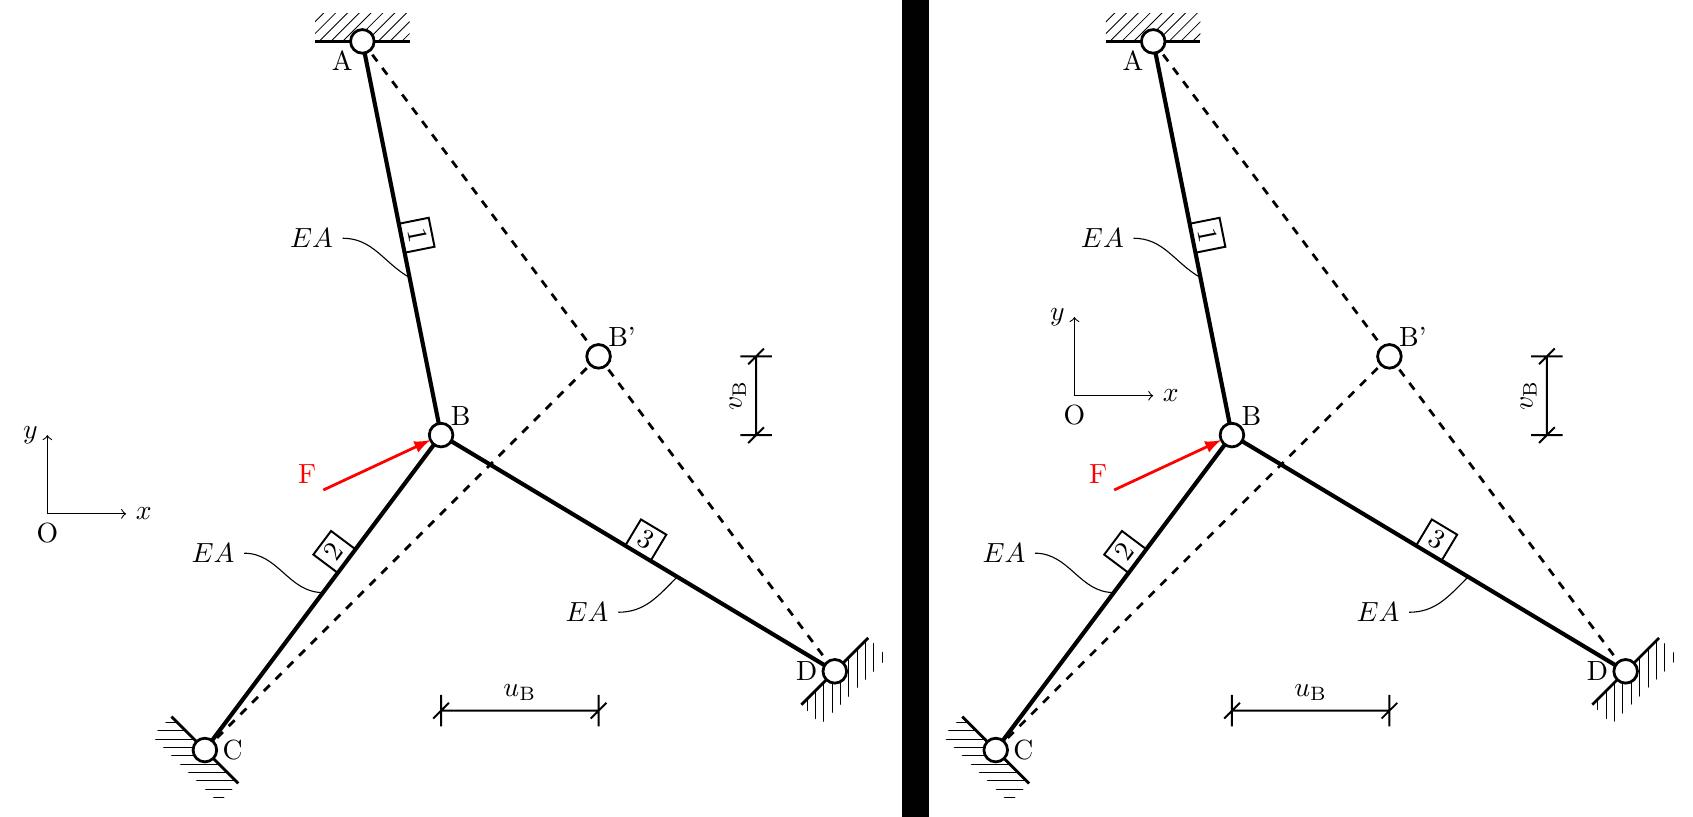

In [ ]:
print(loaded_wrapped["code"])

In [8]:
print(loaded_wrapped["wrapped_exception"])

'tuple' object has no attribute 'sort'


#### property

In [10]:
verifier_visual_property_ds["additional_metadata"]

[{'properties': ['',
   ' Move the origin O of the coordinate system to a point located between the top EA label and the point F, such that the x and y axes are repositioned accordingly.\n',
   ' Ensure the coordinate system remains orthogonal (x',
   'axis horizontal, y',
   'axis vertical) after relocation.\n',
   ' The new origin should lie along the line segment or vicinity between the top EA label and the force vector F, maintaining clarity and avoiding overlap with existing elements.\n',
   " The labels 'x' and 'y' should be clearly visible and oriented correctly relative to the new axes.\n",
   " The position of the coordinate system should not obscure any critical elements like points A, B, C, D, B', or the force F."],
  'properties_eval': [[True, False, True, False, True, False, True, True]]},
 {'properties': ['',
   ' Move the origin O of the coordinate system to a point located between the top EA label and the F force vector.\n',
   ' Ensure the x and y axes are appropriatel

In [ ]:
import json
loaded_wrapped = json.loads(verifier_visual_property_ds["errors"][1]["property_check"][0])

TypeError: the JSON object must be str, bytes or bytearray, not dict

In [7]:
verifier_visual_property_ds["additional_metadata"]

[{'properties': ['',
   ' The coordinate system (origin O with x and y axes) must be relocated so that it is positioned between the top EA element and the force F vector, specifically in the space directly above point B and below the top EA element, ensuring it is centered horizontally between the top EA and F.\n',
   ' The x and y axes of the coordinate system must remain aligned with the horizontal and vertical directions, respectively, as in the original image.\n',
   ' The origin O of the coordinate system must be moved from its current position at the lower',
   'left corner to a new position between the top EA and the force F, maintaining its orientation.'],
  'properties_eval': [[True, True, True, True, True]]},
 {'properties': ['',
   ' Relocate the origin O of the coordinate system to a position midway between the top of the EA label near point A and the point F (the red arrow) at joint B.\n',
   ' Reorient the x and y axes such that they remain orthogonal and aligned with the

#### concat debug

In [14]:
new_conc_dss.unique("approach_name")

['TextVerifier',
 'VisualVerifier',
 'TextVisualVerifier',
 'VisualPropertyVerifier']

In [ ]:
new_conc_dss['usage_metadata']

In [ ]:
new_conc_dss.column_names